### Project 1 - Predicting Exoplanets  

#### David Kinney - DSS 680 - Spring 2021 - Professor Catherine Williams

In [1]:
# %% Import libraries
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, \
                                    accuracy_score, \
                                    precision_score, \
                                    recall_score, \
                                    classification_report
from tpot import TPOTClassifier

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# function definitions

def pca(df):
    
    # standardize the features matrix
    features = StandardScaler().fit_transform(df)
    
    # Create a PCA that retains 99% of the variance
    pca = PCA(n_components = 0.95)
    features_pca = pca.fit_transform(features)
    
    return features, features_pca


def plot_cm(cm):
    # plot confusion matrix
    fig, ax = plt.subplots(figsize = (10,8))
    
    sns.heatmap(conf_matrix_rf/np.sum(conf_matrix_rf), annot=True, 
                fmt='.2%', cmap='Blues', annot_kws={'size':15})
    
    ax.set_title('Random Forest Confusion Matrix', fontsize = 18, loc='left')
    
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
    
    plt.show()

In [4]:
# %% read df_final
# Read the Kepler Objects of Interest (KOI) df_final and look at one observation
df_koi = pd.read_csv('../data/cumulative_2021.03.16_17.10.21.csv')
print(df_koi.shape)
print(df_koi[1:2].T)

(9564, 141)
                                                                    1
rowid                                                               2
kepid                                                        10797460
kepoi_name                                                  K00752.02
kepler_name                                              Kepler-227 c
koi_disposition                                             CONFIRMED
koi_vet_stat                                                     Done
koi_vet_date                                                8/16/2018
koi_pdisposition                                            CANDIDATE
koi_score                                                       0.969
koi_fpflag_nt                                                       0
koi_fpflag_ss                                                       0
koi_fpflag_co                                                       0
koi_fpflag_ec                                                       0
koi_disp

#### clean data  

In [5]:
# Remove variables with no data
df_koi_cleaned = df_koi.dropna(axis=1, how='all')
# Remove variables with no data
df_koi_cleaned = df_koi_cleaned.loc[:, (df_koi_cleaned != 0).any(axis=0)]
# Remove the err columns
df_koi_cleaned = df_koi_cleaned[df_koi_cleaned.columns.drop(
    list(df_koi_cleaned.filter(regex='_err')))]
# Still some variables that are all 0.0; will just drop them manually...
cols = ['koi_eccen','koi_ldm_coeff4','koi_ldm_coeff3']
df_koi_cleaned = df_koi_cleaned.drop(cols,axis=1)

In [6]:
df_koi_cleaned.shape
# %% describe
df_describe = pd.DataFrame(df_koi_cleaned.describe())
print(df_describe)

             rowid         kepid    koi_score  koi_fpflag_nt  koi_fpflag_ss  \
count  9564.000000  9.564000e+03  8054.000000    9564.000000    9564.000000   
mean   4782.500000  7.690628e+06     0.480829       0.208595       0.232748   
std    2761.033321  2.653459e+06     0.476928       4.767290       0.422605   
min       1.000000  7.574500e+05     0.000000       0.000000       0.000000   
25%    2391.750000  5.556034e+06     0.000000       0.000000       0.000000   
50%    4782.500000  7.906892e+06     0.334000       0.000000       0.000000   
75%    7173.250000  9.873066e+06     0.998000       0.000000       0.000000   
max    9564.000000  1.293514e+07     1.000000     465.000000       1.000000   

       koi_fpflag_co  koi_fpflag_ec     koi_period  koi_time0bk     koi_time0  \
count    9564.000000    9564.000000    9564.000000  9564.000000  9.564000e+03   
mean        0.197512       0.120033      75.671358   166.183251  2.454999e+06   
std         0.398142       0.325018    1334.7

In [7]:
# Create subsets based on category
transit_columns = ['koi_period', 'koi_time0bk', 'koi_time0', 'koi_impact', 
                   'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_fittype', 
                   'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor', 
                   'koi_limbdark_mod', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_parm_prov']
tce_columns = ['koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 
               'koi_num_transits', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 
               'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs']
stellar_columns = ['koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_sparprov']
kic_columns = ['ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 
               'koi_jmag', 'koi_hmag', 'koi_kmag']
pixel_columns = ['koi_fwm_sra', 'koi_fwm_sdec', 'koi_fwm_srao', 'koi_fwm_sdeco', 'koi_fwm_prao', 
                 'koi_fwm_pdeco', 'koi_fwm_stat_sig', 'koi_dicco_mra', 'koi_dicco_mdec', 
                 'koi_dicco_msky', 'koi_dikco_mra', 'koi_dikco_mdec', 'koi_dikco_msky']
                 
df_transit = df_koi_cleaned[transit_columns]
df_tce = df_koi_cleaned[tce_columns]
df_stellar = df_koi_cleaned[stellar_columns]
df_kic = df_koi_cleaned[kic_columns]
df_pixel = df_koi_cleaned[pixel_columns]

#### prepare data

In [8]:
"""
Remove all descriptive variables to further simplify the df_final
In the interest of time, remove all categorical variables
"""
remove_cols = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat',
               'koi_vet_date', 'koi_pdisposition', 'koi_fpflag_nt',
               'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov',
               'koi_comment', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname',
               'koi_trans_mod', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs',
               'koi_sparprov', 'koi_fittype']
df_final = df_koi_cleaned.drop(remove_cols, axis=1)

In [9]:
# Separate labels from features
labels = df_final['koi_disposition']
df_features = df_final.drop(['koi_disposition'], axis=1)

# Separate labels from features
imputer = SimpleImputer(strategy="median")
imputer.fit(df_features)
X = imputer.transform(df_features)
df_final = pd.DataFrame(X, columns=df_features.columns, index=df_features.index)

#### Dimensionality Reduction

In [ ]:
# %% correlation matrix before dimentionality reduction
rcParams['figure.figsize'] = 20, 14
plt.matshow(df_final.corr())
plt.yticks(np.arange(df_final.shape[1]), df_final.columns)
plt.xticks(np.arange(df_final.shape[1]), df_final.columns, rotation='vertical')
plt.colorbar()

In [10]:
features, features_pca = pca(df_final)
print('Original number of features: {}'.format(features.shape[1]))
print('Reduced number of features: {}'.format(features_pca.shape[1]))
#df_final = pd.DataFrame(features_pca, columns=df_final.columns, index=df_final.index)

# Uncomment as needed to train on features with or without PCA
# df_features = pd.DataFrame(features_pca)
df_features = pd.DataFrame(features)

Original number of features: 53
Reduced number of features: 29


In [ ]:
# %% correlation matrix after dimentionaloity reduction
rcParams['figure.figsize'] = 20, 14
plt.matshow(df_features.corr())
plt.yticks(np.arange(df_features.shape[1]), df_features.columns)
plt.xticks(np.arange(df_features.shape[1]), df_features.columns, rotation='vertical')
plt.colorbar()

In [11]:
# %% train and test sets
# labels = np.array(labels)
train_features, test_features, train_labels, test_labels = train_test_split(
    df_features, labels, test_size = 0.25, random_state = 42)

In [12]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print('Training distribution: ',train_labels.value_counts(normalize=True))
print('Test distribution: ',test_labels.value_counts(normalize=True))

Training Features Shape: (7173, 53)
Training Labels Shape: (7173,)
Testing Features Shape: (2391, 53)
Testing Labels Shape: (2391,)
Training distribution:  FALSE POSITIVE    0.508853
CANDIDATE         0.246062
CONFIRMED         0.245086
Name: koi_disposition, dtype: float64
Test distribution:  FALSE POSITIVE    0.497700
CANDIDATE         0.251359
CONFIRMED         0.250941
Name: koi_disposition, dtype: float64


#### train baseline model

In [13]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [14]:
predictions = rf.predict(test_features)
print("Accuracy score: ", accuracy_score(test_labels, predictions))
print("Recall score: ", recall_score(test_labels, predictions, average=None))
cv_score = cross_val_score(rf, train_features, train_labels, cv=3, scoring='accuracy')
print("Cross validation score: ", cv_score)
print(classification_report(test_labels,predictions))

Accuracy score:  0.8619824341279799
Recall score:  [0.65723794 0.87       0.96134454]
Cross validation score:  [0.84818068 0.85612714 0.84734421]
                precision    recall  f1-score   support

     CANDIDATE       0.78      0.66      0.71       601
     CONFIRMED       0.86      0.87      0.87       600
FALSE POSITIVE       0.89      0.96      0.93      1190

      accuracy                           0.86      2391
     macro avg       0.85      0.83      0.84      2391
  weighted avg       0.86      0.86      0.86      2391



#### confusion matrix

                  Predicted Candidate  Predicted Confirmed  Predicted FP
Actual Candidate                 1104                  289           372
Actual Confirmed                  198                 1517            43
Actual FP                         163                    7          3480


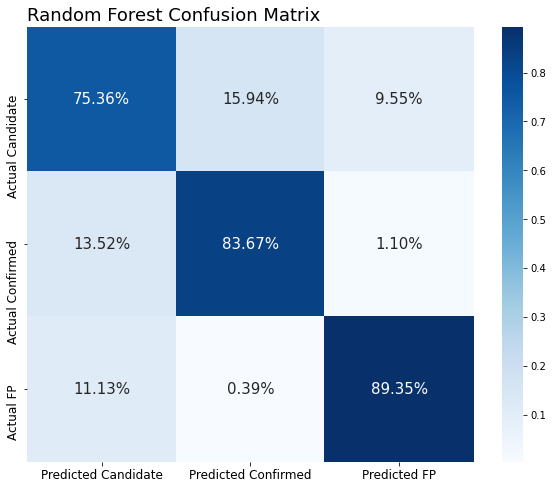

In [15]:
train_pred = cross_val_predict(rf, train_features,train_labels, cv=3)
conf_matrix_rf = pd.DataFrame(confusion_matrix(train_labels, 
                                               train_pred, 
                                               labels=['CANDIDATE','CONFIRMED','FALSE POSITIVE']), 
                              index = ['Actual Candidate', 'Actual Confirmed', 'Actual FP'], 
                              columns = ['Predicted Candidate', 'Predicted Confirmed', 'Predicted FP']
                             )
print(conf_matrix_rf)
plot_cm(conf_matrix_rf)

#### randomized search

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_2 = RandomForestClassifier(random_state = 42)

Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores

In [17]:
rf_random = RandomizedSearchCV(estimator = rf_2, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [18]:
# %% best params - use these params for the next model
print(rf_random.best_params_)

{'n_estimators': 311, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False}


#### Model with Random Search CV Params

In [19]:
rf_rs = RandomForestClassifier(n_estimators = 311,
                               min_samples_split = 5,
                               min_samples_leaf = 1,
                               max_features = 'auto',
                               max_depth = 90,
                               bootstrap = False)

In [20]:
rf_rs.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=False, max_depth=90, min_samples_split=5,
                       n_estimators=311)

In [21]:
print(rf_rs.score(train_features, train_labels))
y_pred = rf_rs.predict(test_features)
print(accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))

1.0
0.8665830196570473
                precision    recall  f1-score   support

     CANDIDATE       0.78      0.68      0.73       601
     CONFIRMED       0.86      0.87      0.87       600
FALSE POSITIVE       0.90      0.96      0.93      1190

      accuracy                           0.87      2391
     macro avg       0.85      0.84      0.84      2391
  weighted avg       0.86      0.87      0.86      2391



                  Predicted Candidate  Predicted Confirmed  Predicted FP
Actual Candidate                  367                  107           127
Actual Confirmed                   66                  519            15
Actual FP                          63                    3          1124


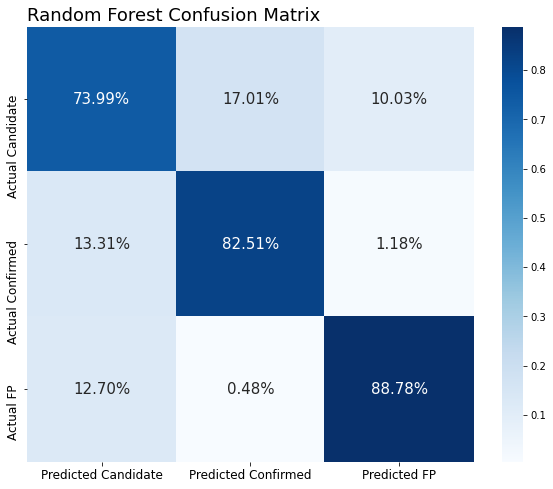

In [22]:
# confusion matrix & accuracy
rs_pred = cross_val_predict(rf_rs, test_features,test_labels, cv=3)
conf_matrix_rf = confusion_matrix(test_labels, rs_pred)
conf_matrix_rf = pd.DataFrame(confusion_matrix(test_labels, 
                                               rs_pred, 
                                               labels=['CANDIDATE','CONFIRMED','FALSE POSITIVE']), 
                              index = ['Actual Candidate', 'Actual Confirmed', 'Actual FP'], 
                              columns = ['Predicted Candidate', 'Predicted Confirmed', 'Predicted FP']
                             )
print(conf_matrix_rf)
plot_cm(conf_matrix_rf)

In [23]:
print("Accuracy score: ", accuracy_score(test_labels, rs_pred))
print("Recall score: ", recall_score(test_labels, rs_pred, average=None))
print("Precision score: ", precision_score(test_labels, rs_pred, average=None))

Accuracy score:  0.8406524466750314
Recall score:  [0.61064892 0.865      0.94453782]
Precision score:  [0.73991935 0.82511924 0.8878357 ]


TPOT is an open-source library for performing AutoML in Python. It makes use of the popular Scikit-Learn machine learning library for data transforms and machine learning algorithms and uses a Genetic Programming stochastic global search procedure to efficiently discover a top-performing model pipeline for a given dataset. [1](https://machinelearningmastery.com/tpot-for-automated-machine-learning-in-python/)

In [24]:
# TPOT

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

In [25]:
tpot_classifier = TPOTClassifier(generations= 5, 
                                 population_size= 24, 
                                 offspring_size= 12,
                                 verbosity= 2, 
                                 early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                                 cv = 4, 
                                 scoring = 'accuracy')
tpot_classifier.fit(train_features, train_labels)
accuracy = tpot_classifier.score(test_features, test_labels)
print(accuracy)

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8526419788089566

Generation 2 - Current best internal CV score: 0.8529211519342221

Generation 3 - Current best internal CV score: 0.8531991592474387

Generation 4 - Current best internal CV score: 0.8533390566932845

Generation 5 - Current best internal CV score: 0.8533390566932845

Best pipeline: RandomForestClassifier(input_matrix, criterion=entropy, max_depth=450, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1600)


ValueError: could not convert string to float: 'CANDIDATE'

#### AdaBoost Classifier

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(train_features, train_labels)
ada_pred = ada_clf.predict(test_features)

In [27]:
print(classification_report(test_labels, ada_pred))

                precision    recall  f1-score   support

     CANDIDATE       0.69      0.59      0.64       601
     CONFIRMED       0.82      0.87      0.84       600
FALSE POSITIVE       0.89      0.93      0.91      1190

      accuracy                           0.83      2391
     macro avg       0.80      0.80      0.80      2391
  weighted avg       0.82      0.83      0.82      2391



#### SVM

In [28]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(train_features, train_labels)
svm_preds = svm_clf.predict(test_features)

In [29]:
print(classification_report(test_labels, ada_pred))

                precision    recall  f1-score   support

     CANDIDATE       0.69      0.59      0.64       601
     CONFIRMED       0.82      0.87      0.84       600
FALSE POSITIVE       0.89      0.93      0.91      1190

      accuracy                           0.83      2391
     macro avg       0.80      0.80      0.80      2391
  weighted avg       0.82      0.83      0.82      2391



#### XGBoost

In [30]:
import xgboost as xgb

le = LabelEncoder()
train_labels_encoded = le.fit_transform(list(train_labels))
test_labels_encoded = le.fit_transform(list(test_labels))
                              
D_train = xgb.DMatrix(train_features, label=train_labels_encoded)
D_test = xgb.DMatrix(test_features, label=test_labels_encoded)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20

model = xgb.train(param, D_train, steps)

[15:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [31]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(test_labels_encoded, best_preds, average='macro')))
print("Recall = {}".format(recall_score(test_labels_encoded, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(test_labels_encoded, best_preds)))

Precision = 0.8326061430261088
Recall = 0.8211789951698926
Accuracy = 0.8523630280217482


In [32]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(train_features, train_labels_encoded)

KeyboardInterrupt: 

In [ ]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(test_labels_encoded, best_preds, average='macro')))
print("Recall = {}".format(recall_score(test_labels_encoded, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(test_labels_encoded, best_preds)))

### Multi-classification using Keras  

<mark>**I did not get this to run, but is definitely something I'd like to revisit once the semester is over.**</mark>

In [ ]:
# Vectorize the labels
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [ ]:
# Build and compile a model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(53,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_features, test_labels))

In [ ]:
results = history.evaluate(test_features, one_hot_test_labels)

In [ ]:
# Plot loss and accuracy curves
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()